<h1 align="center">Tidying up LFP data from matlab cell array -  Control</h1> 

In [1]:
!date

Sat Mar  5 13:13:36 PST 2022


___

## Manually define the following parameters:

#### Define matlab files to analyze

In [2]:
files = "data/control*"

#### Define experiment condition (for figure titles)

In [3]:
condition = "Control"

#### Define bird IDs

In [4]:
bird1 = "Or295"
bird2 = "PK31"

#### Define maximum frequency. Power values for frequencies above freq_max will be discarded

In [5]:
freq_max = 500

#### Define start indeces of freq. ranges to sum, e.g. ranges 1-10, 11-100, and 101-end (manual log scale) power values for this hour
For the log scale, define the last slice to start at position 95 because frequencies 58-62 Hz will be removed due to American outlet noise and then frequency 101 Hz will be located at index 95.

In [6]:
freq_range = [0, 11, 96]

freq_range_label = ["1-10", "11-100", f"101-{freq_max}"]

#### Define number of morning hours

In [7]:
m_hours = 5

#### Define channels to be excluded because they are likely outside HVC

In [8]:
outside_HVC = [3, 7, 11, 15, 1, 5, 9, 13]

#### Define whether to keep only one channel or average across all channels
Excluding channels with broken electrodes and channels outside HVC.

In [9]:
# Define as "multi" or "single"
channels_used = "multi"

#### Make sure to define the days-to-dpi mapping and channels with broken electrodes to be removed below!

___

## Import packages

In [10]:
%load_ext blackcellmagic
%config InlineBackend.figure_format='retina'

In [11]:
import glob
import scipy.io as sio

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

___

## Load data (cellarrays generated from raw data in matlab)

In [12]:
# Get all files to analyze
glob.glob(files)

['data/control_09_25_09_28_evening_bulk_power.mat',
 'data/control_09_29_09_30_evening_bulk_power.mat',
 'data/control_11_08_11_21_evening_bulk_power.mat',
 'data/control_09_02_00_00_evening_bulk_power.mat',
 'data/control_10_20_11_05_morning_bulk_power.mat',
 'data/control_09_11_09_13_evening_bulk_power.mat',
 'data/control_11_23_00_00_morning_bulk_power.mat',
 'data/control_09_14_09_23_evening_bulk_power.mat',
 'data/control_12_14_12_16_evening_bulk_power.mat',
 'data/control_10_02_10_18_morning_bulk_power.mat',
 'data/control_11_23_00_00_evening_bulk_power.mat',
 'data/control_12_14_12_16_morning_bulk_power.mat',
 'data/control_10_02_10_18_evening_bulk_power.mat',
 'data/control_09_14_09_23_morning_bulk_power.mat',
 'data/control_09_02_00_00_morning_bulk_power.mat',
 'data/control_10_20_11_05_evening_bulk_power.mat',
 'data/control_11_08_11_21_morning_bulk_power.mat',
 'data/control_09_11_09_13_morning_bulk_power.mat',
 'data/control_09_29_09_30_morning_bulk_power.mat',
 'data/contr

Raw power values are stored in tab 'evening_rec_chan_cell' and 'morning_rec_chan_cell' inside each mat file.

### !!! Files with 00_00 date do not include successive days and need custom day adjustment:
Date legend:  
09_02_00_00: 09/02, 09/03, 09/04, 09/05, 09/06, 09/07, 09/08, 09/10 - ONLY CONTAINS DATA FROM Or295  
11_23_00_00: 11/23, 11/24, 11/25, 11/26, 11/27, 11/28, 11/29, 11/30, 12/01, 12/05, 12/07, 12/08, 12/09

## Create a tidy data frame containing raw power values for morning and evening data
Note: The second, fourth and fifth array of each mat_contents file are empty and have no meaning. They are a side effect of the cellarray structure in matlab.

In [13]:
%%time
# Create empty lists to record data from all files
dates_all = []
recs_all = []
channels_all = []
hours_all = []
power_all = []
daytimes_all = []
freqs_all = []

# Define frequencies to be kept in final tidy dataframe (excluding freqs 58-62 Hz due to American outlet noise)
temp = np.arange(0,freq_max) + 1
freq_range_clean = np.concatenate([temp[:57], temp[62:freq_max]])

for file in glob.glob(files):
    # Add some space between print outs
    print(" ")
    
    # Load matlab file
    mat_contents = sio.loadmat(file)
    sub_folder = list(mat_contents.keys())[-1]
    # Get the date from the file name
    d = "-".join(["/".join(file.split("/")[-1].split("_")[1:3]), "/".join(file.split("/")[-1].split("_")[3:5])])
    # Get the daytime (morning or evening) from the file name
    daytime = file.split("/")[-1].split("_")[5]
    
    # Find number of days recorded
    n_recs = len(mat_contents[sub_folder])
    
    # Print some info about the data
    print("Date: ", d)
    print("Daytime: ", daytime)
    print("Filename: ", file)
    print("Subfolder: ", sub_folder)
    print("Days recorded: ", n_recs)
    
    # Create empty lists to record data from this day
    dates = []
    recs = []
    channels = []
    hours = []
    power = []
    daytimes = []
    freqs = []

    for rec in range(n_recs):
        # Find number of channels in this recording
        n_channels = len(mat_contents[sub_folder][rec][0])
        print(f"Channels in day {rec}: ", n_channels)
        
        # Only include days that were actually recorded and hence have > 1 channels
        if n_channels > 1:
            for channel in range(n_channels):
                # Find number of hours in this channel
                n_hours = len(mat_contents[sub_folder][rec][0][channel][0])  
                
                # Print number of hours if it is not 5 (expected value)
                if n_hours != 5:
                        print(f"Number of hours in day {rec}, channel {channel}: ", n_hours)

                for hour in range(n_hours):
                    # Print number of power values if it is not 800 (expected value)
                    if len(mat_contents[sub_folder][rec][0][channel][0][hour][0][0]) != 800:
                        print(f"Number of power values in day {rec}, channel {channel}, hour {hour}: ", len(mat_contents[sub_folder][rec][0][channel][0][hour][0][0]))
                    
                    # Get power values for frequencies 1 - freq_max, removing frequencies 58 - 62 (American outlet noise)
                    powers = np.concatenate([mat_contents[sub_folder][rec][0][channel][0][hour][0][0][:57], mat_contents[sub_folder][rec][0][channel][0][hour][0][0][62:freq_max]]) 
                    
                    ## Append the power values with their corresponding information to lists
                    power.append(powers)
                    dates.append([d,] * len(powers))
                    recs.append([[rec],] * len(powers))
                    # Add 1 to channel to correct for Python 0 indexing
                    channels.append([channel+1,] * len(powers))
                    hours.append([hour,] * len(powers))
                    daytimes.append([daytime,] * len(powers))
                    freqs.append(freq_range_clean)

    # Concatenate the lists                
    power = np.concatenate(power)
    dates = np.concatenate(dates)
    recs = np.concatenate(recs)
    channels = np.concatenate(channels)
    hours = np.concatenate(hours)
    daytimes = np.concatenate(daytimes)
    freqs = np.concatenate(freqs)  
    
    # Append the information from this day to the lists containing info from all files 
    dates_all.append(dates)
    recs_all.append(recs)
    channels_all.append(channels)
    hours_all.append(hours)
    power_all.append(power)
    daytimes_all.append(daytimes)
    freqs_all.append(freqs)

 
Date:  09/25-09/28
Daytime:  evening
Filename:  data/control_09_25_09_28_evening_bulk_power.mat
Subfolder:  evening_rec_chan_cell
Days recorded:  4
Channels in day 0:  32
Channels in day 1:  32
Channels in day 2:  32
Channels in day 3:  32
 
Date:  09/29-09/30
Daytime:  evening
Filename:  data/control_09_29_09_30_evening_bulk_power.mat
Subfolder:  evening_rec_chan_cell
Days recorded:  2
Channels in day 0:  38
Number of hours in day 0, channel 32:  0
Number of hours in day 0, channel 33:  0
Number of hours in day 0, channel 34:  0
Number of hours in day 0, channel 35:  0
Number of hours in day 0, channel 36:  0
Number of hours in day 0, channel 37:  0
Channels in day 1:  38
Number of hours in day 1, channel 32:  0
Number of hours in day 1, channel 33:  0
Number of hours in day 1, channel 34:  0
Number of hours in day 1, channel 35:  0
Number of hours in day 1, channel 36:  0
Number of hours in day 1, channel 37:  0
 
Date:  11/08-11/21
Daytime:  evening
Filename:  data/control_11_08_1

!!! Note: File from 09/29-09/30 contained accelerometer data in channels 33-38 (indexed at 32-37). Those arrays are now empty and are not included in the data frame below.

Create data frame from lists containing info from all files:

In [14]:
%%time
power_all = np.concatenate(power_all)
dates_all = np.concatenate(dates_all)
recs_all = np.concatenate(recs_all)
channels_all = np.concatenate(channels_all)
hours_all = np.concatenate(hours_all)
daytimes_all = np.concatenate(daytimes_all)
freqs_all = np.concatenate(freqs_all)

# Create data frame
df_orig = pd.DataFrame()
df_orig["date"] = dates_all
df_orig["daytime"] = daytimes_all
df_orig["day"] = recs_all
df_orig["channel"] = channels_all
df_orig["hour"] = hours_all
df_orig["freq"] = freqs_all
df_orig["power"] = power_all

CPU times: user 3.82 s, sys: 1.69 s, total: 5.51 s
Wall time: 5.54 s


In [15]:
# Add experiment condition to data frame
df_orig["condition"] = condition

df_orig

,date,daytime,day,channel,hour,freq,power,condition
0,09/25-09/28,evening,0,1,0,1,41150.543985,Control
1,09/25-09/28,evening,0,1,0,2,46469.932846,Control
2,09/25-09/28,evening,0,1,0,3,37119.393080,Control
3,09/25-09/28,evening,0,1,0,4,27410.264419,Control
4,09/25-09/28,evening,0,1,0,5,20673.415778,Control
...,...,...,...,...,...,...,...,...
13305595,09/25-09/28,morning,3,32,4,496,96.834211,Control
13305596,09/25-09/28,morning,3,32,4,497,96.449566,Control
13305597,09/25-09/28,morning,3,32,4,498,97.117705,Control
13305598,09/25-09/28,morning,3,32,4,499,101.307380,Control


___

# Rename "hour" to represent morning (hours 0-4) and evening (hours 5-9)

In [16]:
df_orig["hour"].unique()

array([0, 1, 2, 3, 4])

In [17]:
# Add 5 to "hour" values where "daytime" = "evening"
df_orig.loc[df_orig["daytime"] == "evening", "hour"] += m_hours

# Show new hours
np.sort(df_orig["hour"].unique())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Drop the last hour of each morning and the last two hours of each evening recording in case the bird already started singing 
Morning: Drop the last hour, since the bird is more likely to sing in the first 4 hours.  
Evening: Only the first three hours are kept for each recording (these are hours 7,8,9 since the evening hours are labeled backwards).

In [18]:
for hour in [4, 5, 6]:
    df_orig = df_orig[df_orig.hour != hour]

# Show new hours
np.sort(df_orig["hour"].unique())

array([0, 1, 2, 3, 7, 8, 9])

___

# Split data from different birds

In [19]:
df_bird1 = df_orig.loc[df_orig["channel"] <= 16]
df_bird1["animal_ID"] = bird1

/var/folders/v8/1_xrn19n71s8w4gbd_215tnr0000gn/T/ipykernel_2368/1710075169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bird1["animal_ID"] = bird1


In [20]:
df_bird2 = df_orig.loc[df_orig["channel"] > 16]
df_bird2["animal_ID"] = bird2
# Substract 16 from channels of bird 2, since its channels were saved as 16-31 instead of 0-15
df_bird2["channel"] -= 16

/var/folders/v8/1_xrn19n71s8w4gbd_215tnr0000gn/T/ipykernel_2368/2512377287.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bird2["animal_ID"] = bird2
/var/folders/v8/1_xrn19n71s8w4gbd_215tnr0000gn/T/ipykernel_2368/2512377287.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bird2["channel"] -= 16


In [21]:
df_bird2.head()

,date,daytime,day,channel,hour,freq,power,condition,animal_ID
40590,09/25-09/28,evening,0,1,7,1,4820.284744,Control,PK31
40591,09/25-09/28,evening,0,1,7,2,5337.561514,Control,PK31
40592,09/25-09/28,evening,0,1,7,3,4611.990490,Control,PK31
40593,09/25-09/28,evening,0,1,7,4,3813.795944,Control,PK31
40594,09/25-09/28,evening,0,1,7,5,2952.470486,Control,PK31


___

# Fix the "day" column so days correctly reflect dpi (day post injection) for each bird

### !!! Files with 00_00 date do not include successive days and need custom day adjustment:
Date legend:  
09_02_00_00: 09/02, 09/03, 09/04, 09/05, 09/06, 09/07, 09/08, 09/10 - ONLY CONTAINS DATA FROM Or295  
11_23_00_00: 11/23, 11/24, 11/25, 11/26, 11/27, 11/28, 11/29, 11/30, 12/01, 12/05, 12/07, 12/08, 12/09

In [22]:
# Show unique days before dpi correction
df_bird1["day"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [23]:
# Show dates of files
np.sort(df_bird1["date"].unique())

array(['09/02-00/00', '09/11-09/13', '09/14-09/23', '09/25-09/28',
       '09/29-09/30', '10/02-10/18', '10/20-11/05', '11/08-11/21',
       '11/23-00/00', '12/14-12/16'], dtype=object)

In [24]:
# Set dpi for files with non-consecutive days based on date-day mapping (see csv file)
# 09/10
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 7)), "day"] = 9
# 09/08
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 6)), "day"] = 7
# 09/07
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 5)), "day"] = 6
# 09/06
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 4)), "day"] = 5
# 09/05
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 3)), "day"] = 4
# 09/04
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 2)), "day"] = 3
# 09/03
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 1)), "day"] = 2
# 09/02
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 0)), "day"] = 1

# 11/23
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 0)), "day"] = 83
# 11/24
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 1)), "day"] = 84
# 11/25
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 2)), "day"] = 85
# 11/26
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 3)), "day"] = 86
# 11/27
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 4)), "day"] = 87
# 11/28
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 5)), "day"] = 88
# 11/29
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 6)), "day"] = 89
# 11/30
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 7)), "day"] = 90
# 12/01
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 8)), "day"] = 91
# 12/05
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 9)), "day"] = 95
# 12/07
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 10)), "day"] = 97
# 12/08
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 11)), "day"] = 98
# 12/09
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 12)), "day"] = 99

# Add n days to "day" values based on date-day mapping (see csv file)
df_bird1.loc[df_bird1["date"] == "09/11-09/13", "day"] += 10
df_bird1.loc[df_bird1["date"] == "09/14-09/23", "day"] += 13
df_bird1.loc[df_bird1["date"] == "09/25-09/28", "day"] += 24
df_bird1.loc[df_bird1["date"] == "09/29-09/30", "day"] += 28
df_bird1.loc[df_bird1["date"] == "10/02-10/18", "day"] += 31
df_bird1.loc[df_bird1["date"] == "10/20-11/05", "day"] += 49
df_bird1.loc[df_bird1["date"] == "11/08-11/21", "day"] += 68
df_bird1.loc[df_bird1["date"] == "12/14-12/16", "day"] += 104

/Users/lauraluebbert/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/lauraluebbert/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [25]:
# Show dpis for bird 1
np.sort(df_bird1["day"].unique())

array([  1,   2,   3,   4,   5,   6,   7,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  24,  25,  26,  27,  28,
        29,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  95,  97,  98,  99, 104, 105, 106])

#### Double-check that days were labeled correctly for bird 1:

In [26]:
days_collected_b1 = [1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24,25,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,68,69,70,71,72,73,74,75,76,77,78,79,80,83,84,85,86,87,88,89,90,91,95,97,98,99,104,105,106]

# Raise error if collected days is not the same as days labeled in df
difference = set(np.sort(df_bird1["day"].unique())).symmetric_difference(set(days_collected_b1))
list_difference = list(difference)
if len(list_difference)>0:
    raise ValueError(f'Newly labeled days does not equal collected days for {bird1}. The following DPIs do not match: {list_difference}')
else:
    print(f'Newly labeled days equals collected days for {bird1}.')

Newly labeled days equals collected days for Or295.


### Same for bird 2:

In [27]:
# Show unique days before dpi correction
df_bird2["day"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [28]:
# Show dates of files
np.sort(df_bird2["date"].unique())

array(['09/11-09/13', '09/14-09/23', '09/25-09/28', '09/29-09/30',
       '10/02-10/18', '10/20-11/05', '11/08-11/21', '11/23-00/00',
       '12/14-12/16'], dtype=object)

In [29]:
# 11/23
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 0)), "day"] = 74
# 11/24
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 1)), "day"] = 75
# 11/25
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 2)), "day"] = 76
# 11/26
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 3)), "day"] = 77
# 11/27
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 4)), "day"] = 78
# 11/28
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 5)), "day"] = 79
# 11/29
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 6)), "day"] = 80
# 11/30
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 7)), "day"] = 81
# 12/01
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 8)), "day"] = 82
# 12/05
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 9)), "day"] = 86
# 12/07
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 10)), "day"] = 88
# 12/08
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 11)), "day"] = 89
# 12/09
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 12)), "day"] = 90

# Add n days to "day" values based on date-day mapping (see csv file)
df_bird2.loc[df_bird2["date"] == "09/11-09/13", "day"] += 1
df_bird2.loc[df_bird2["date"] == "09/14-09/23", "day"] += 4
df_bird2.loc[df_bird2["date"] == "09/25-09/28", "day"] += 15
df_bird2.loc[df_bird2["date"] == "09/29-09/30", "day"] += 19
df_bird2.loc[df_bird2["date"] == "10/02-10/18", "day"] += 22
df_bird2.loc[df_bird2["date"] == "10/20-11/05", "day"] += 40
df_bird2.loc[df_bird2["date"] == "11/08-11/21", "day"] += 59
df_bird2.loc[df_bird2["date"] == "12/14-12/16", "day"] += 95

In [30]:
# Show dpis for bird 2
np.sort(df_bird2["day"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18,
       19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 77, 78,
       79, 80, 81, 82, 86, 88, 89, 90, 95, 96, 97])

#### Double-check that days were labeled correctly for bird 2:

In [31]:
days_collected_b2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,59,60,61,62,63,64,65,66,67,68,69,70,71,74,75,76,77,78,79,80,81,82,86,88,89,90,95,96,97]

# Raise error if collected days is not the same as days labeled in df
difference = set(np.sort(df_bird2["day"].unique())).symmetric_difference(set(days_collected_b2))
list_difference = list(difference)
if len(list_difference)>0:
    raise ValueError(f'Newly labeled days does not equal collected days for {bird2}. The following DPIs do not match: {list_difference}')
else:
    print(f'Newly labeled days equals collected days for {bird2}.')

Newly labeled days equals collected days for PK31.


___

# Remove broken electrode channels

Average over all days and hours:

In [32]:
# Bird 1
df_bird1_test = df_bird1.groupby(["daytime", "channel", "freq"])[["power"]].apply(np.mean)
df_bird1_test = df_bird1_test.reset_index()

# Bird 2
df_bird2_test = df_bird2.groupby(["daytime", "channel", "freq"])[["power"]].apply(np.mean)
df_bird2_test = df_bird2_test.reset_index()
df_bird2_test

,daytime,channel,freq,power
0,evening,1,1,3963.250342
1,evening,1,2,4897.078343
2,evening,1,3,4483.693995
3,evening,1,4,3757.361712
4,evening,1,5,2958.133843
...,...,...,...,...
15835,morning,16,496,358.502909
15836,morning,16,497,358.903894
15837,morning,16,498,359.899252
15838,morning,16,499,361.832820


Plot power values over frequency for each channel:

In [33]:
def plot_channels(temp_df, bird_ID):
    """
    Plots power values over frequency on a log scale for each channel.
    Morning and evening data are plotted separately.
    """
    
    fig, axs = plt.subplots(figsize=(20, 20), ncols=4, nrows=4)
    ax_col = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
    ax_row = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

    for channel, (ax_col, ax_row) in zip(temp_df["channel"].unique(), zip(ax_col, ax_row)):
        temp_df2 = temp_df.loc[temp_df["channel"] == channel]
        temp_df2 = temp_df2.groupby("daytime")

        ax = axs[ax_col, ax_row]

        for name, group in temp_df2:
            ax.plot(group["freq"], group["power"], label=name, marker='o', markersize=2, linestyle='', linewidth=2)

        ax.set(**{
            "xlabel": "Freq. (Hz)",
            "ylabel": "Power",
            "title": "{} {} - Channel {}".format(condition, bird_ID, channel)
        })

        # Change axes to log scale
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(top=100000)

        # Add legend
        ax.legend()

    plt.tight_layout()        
    fig.show()

## Bird 1:

/var/folders/v8/1_xrn19n71s8w4gbd_215tnr0000gn/T/ipykernel_2368/2944711502.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


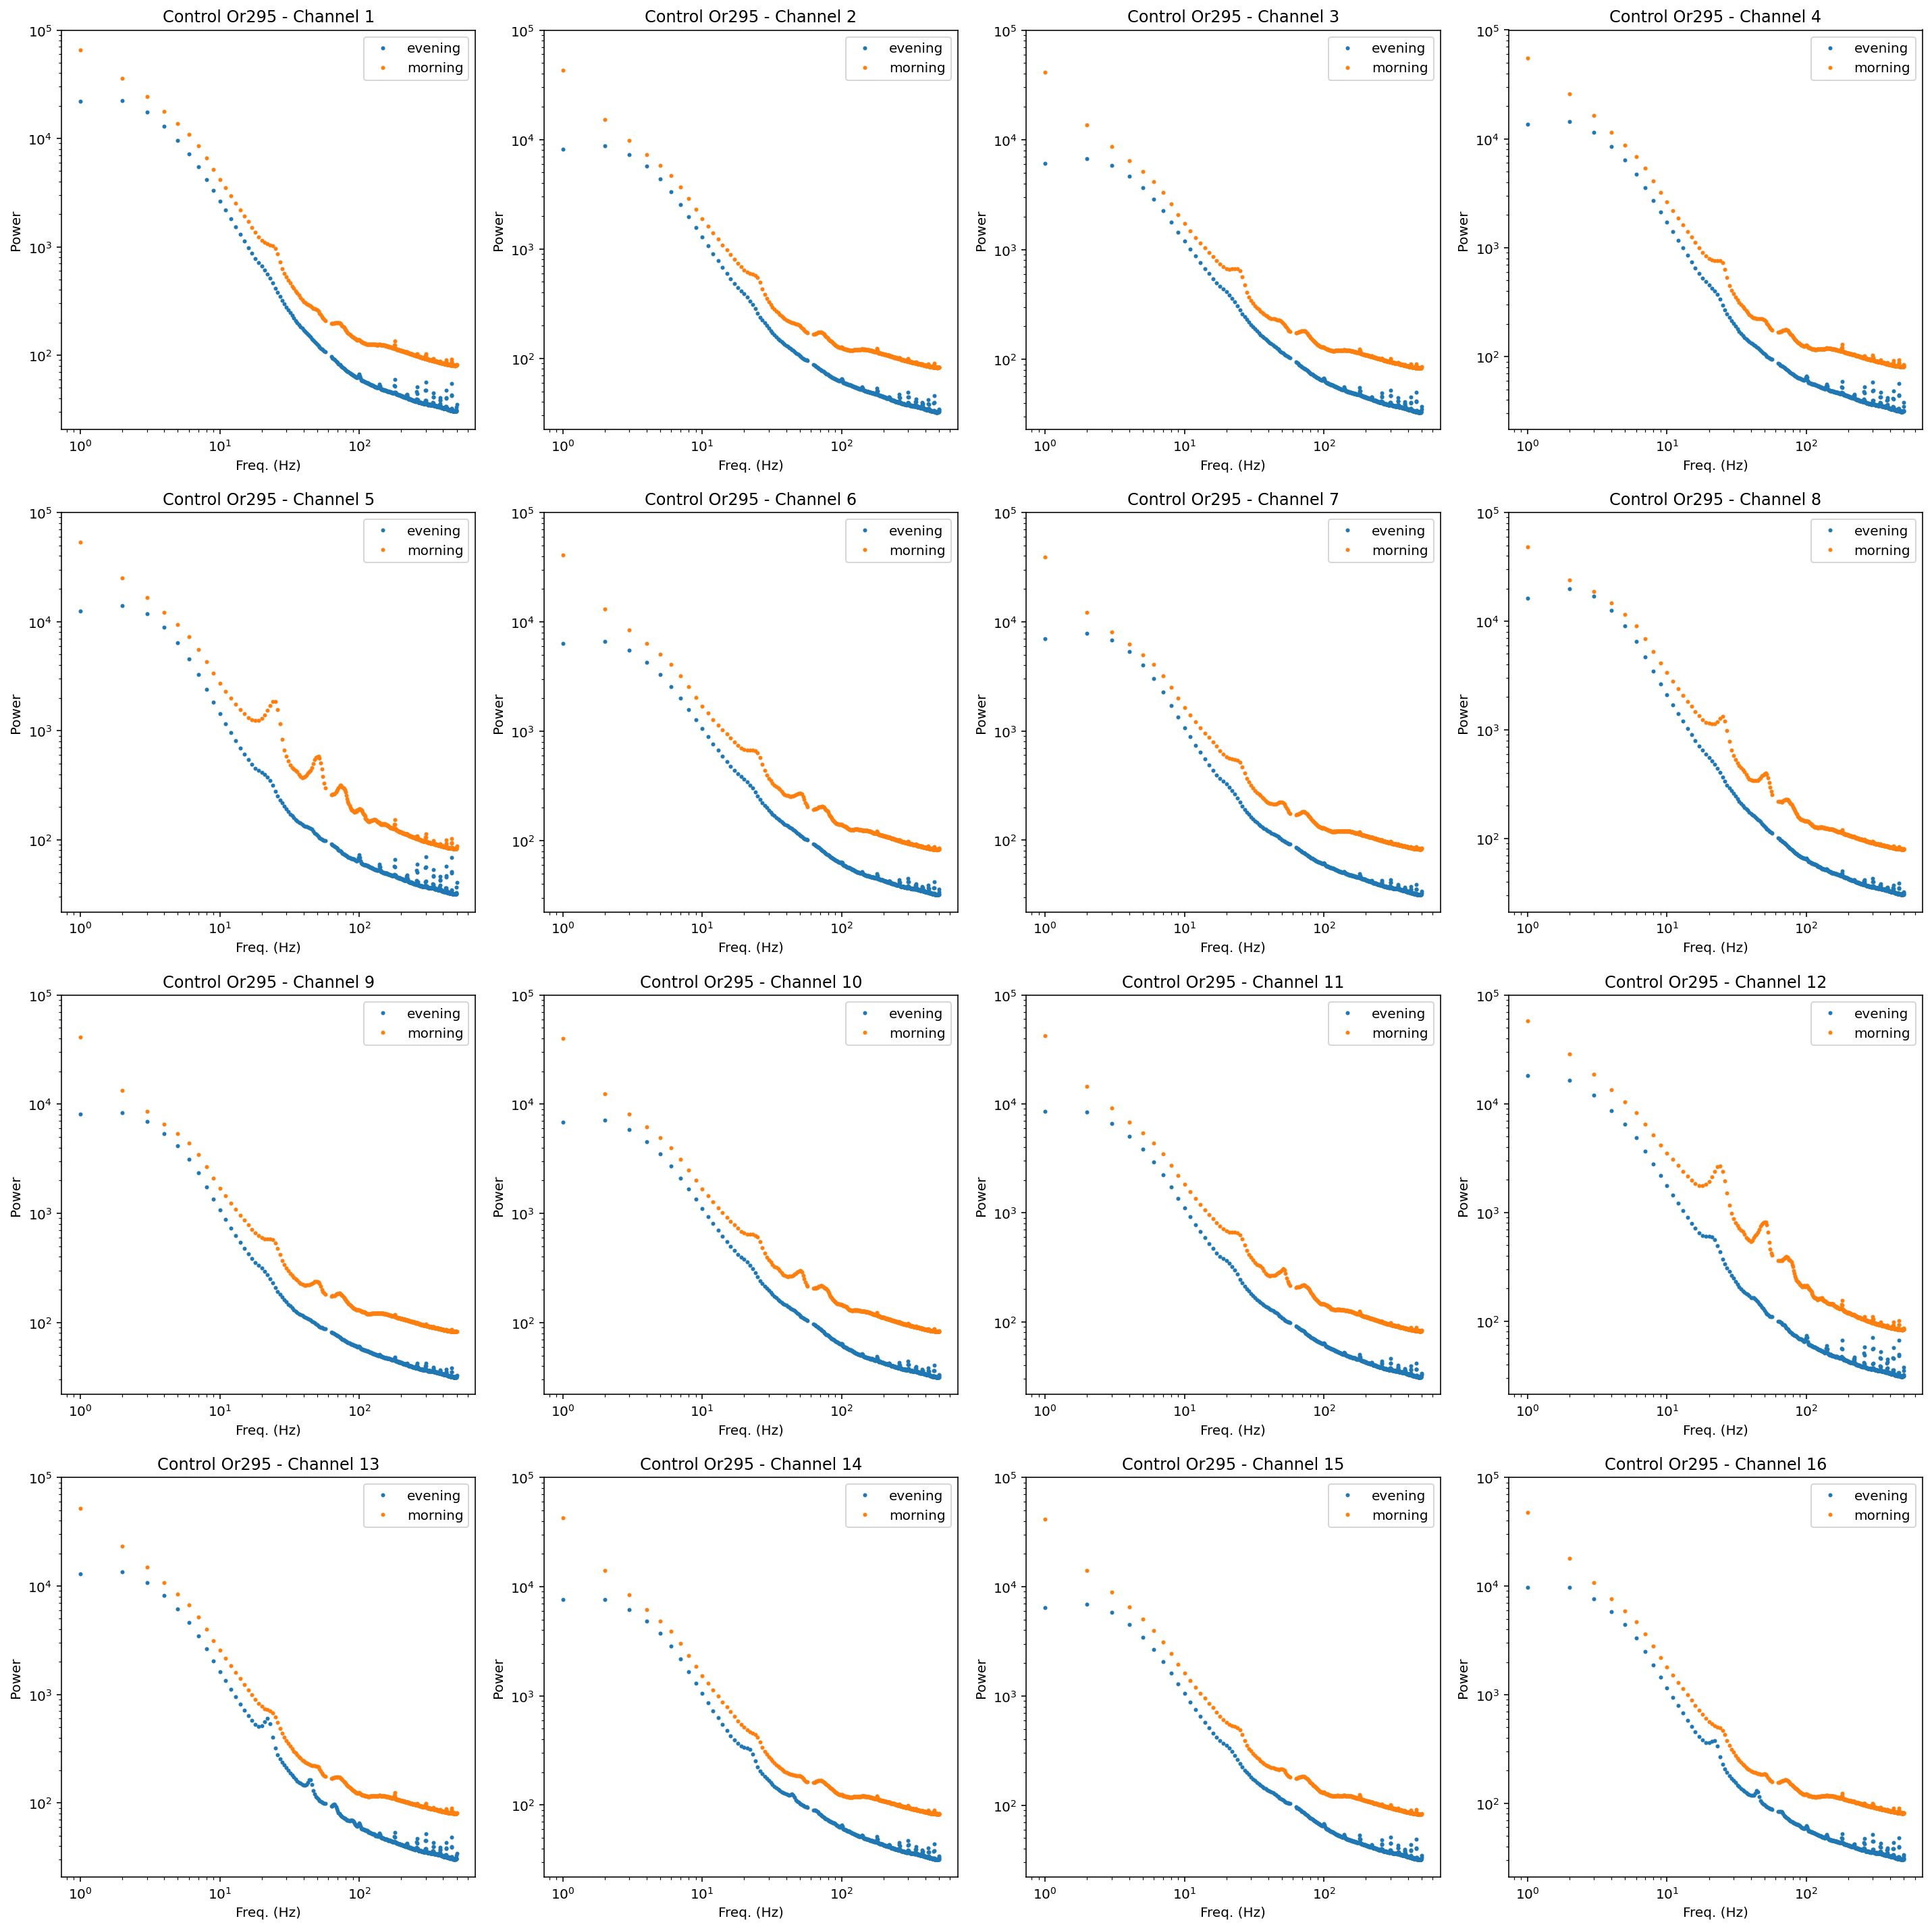

In [34]:
plot_channels(df_bird1_test, bird1)

#### !!! Manually define channels with broken electrodes to be removed from bird 1 data OR define single channel to keep

Note: Based on wavelet transform data during singing, we decided to keep channels 2,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16 for Or295.

In [35]:
# If averaging over multiple channels:
# Define channels with broken electrodes to remove (leave array empty if none)
bad_channels_b1 = [1, 3, 4, 5, 12]

# If only keeping one single channel (ignored if channels_used == "multi"):
single_channel = 2

In [36]:
if channels_used == "single":
    bad_channels_b1 = df_bird1['channel'].unique()[df_bird1['channel'].unique() != single_channel]

In [37]:
for bad_channel in np.concatenate((bad_channels_b1, outside_HVC)):
    # Exclude bad channels and channels located outside HVC from test df (power values averaged across all days)
    df_bird1_test = df_bird1_test[df_bird1_test.channel != bad_channel]
    
    # Exclude bad channels and channels located outside HVC from original df
    df_bird1 = df_bird1[df_bird1.channel != bad_channel]
    
# for bad_channel in bad_channels_b1:
#     # Exclude bad channels from test df (power values averaged across all days)
#     df_bird1_test = df_bird1_test[df_bird1_test.channel != bad_channel]
    
#     # Exclude bad channels from original df
#     df_bird1 = df_bird1[df_bird1.channel != bad_channel]

In [38]:
# Show new channel list
df_bird1['channel'].unique()

array([ 2,  6,  8, 10, 14, 16])

## Same for bird 2:

/var/folders/v8/1_xrn19n71s8w4gbd_215tnr0000gn/T/ipykernel_2368/2944711502.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


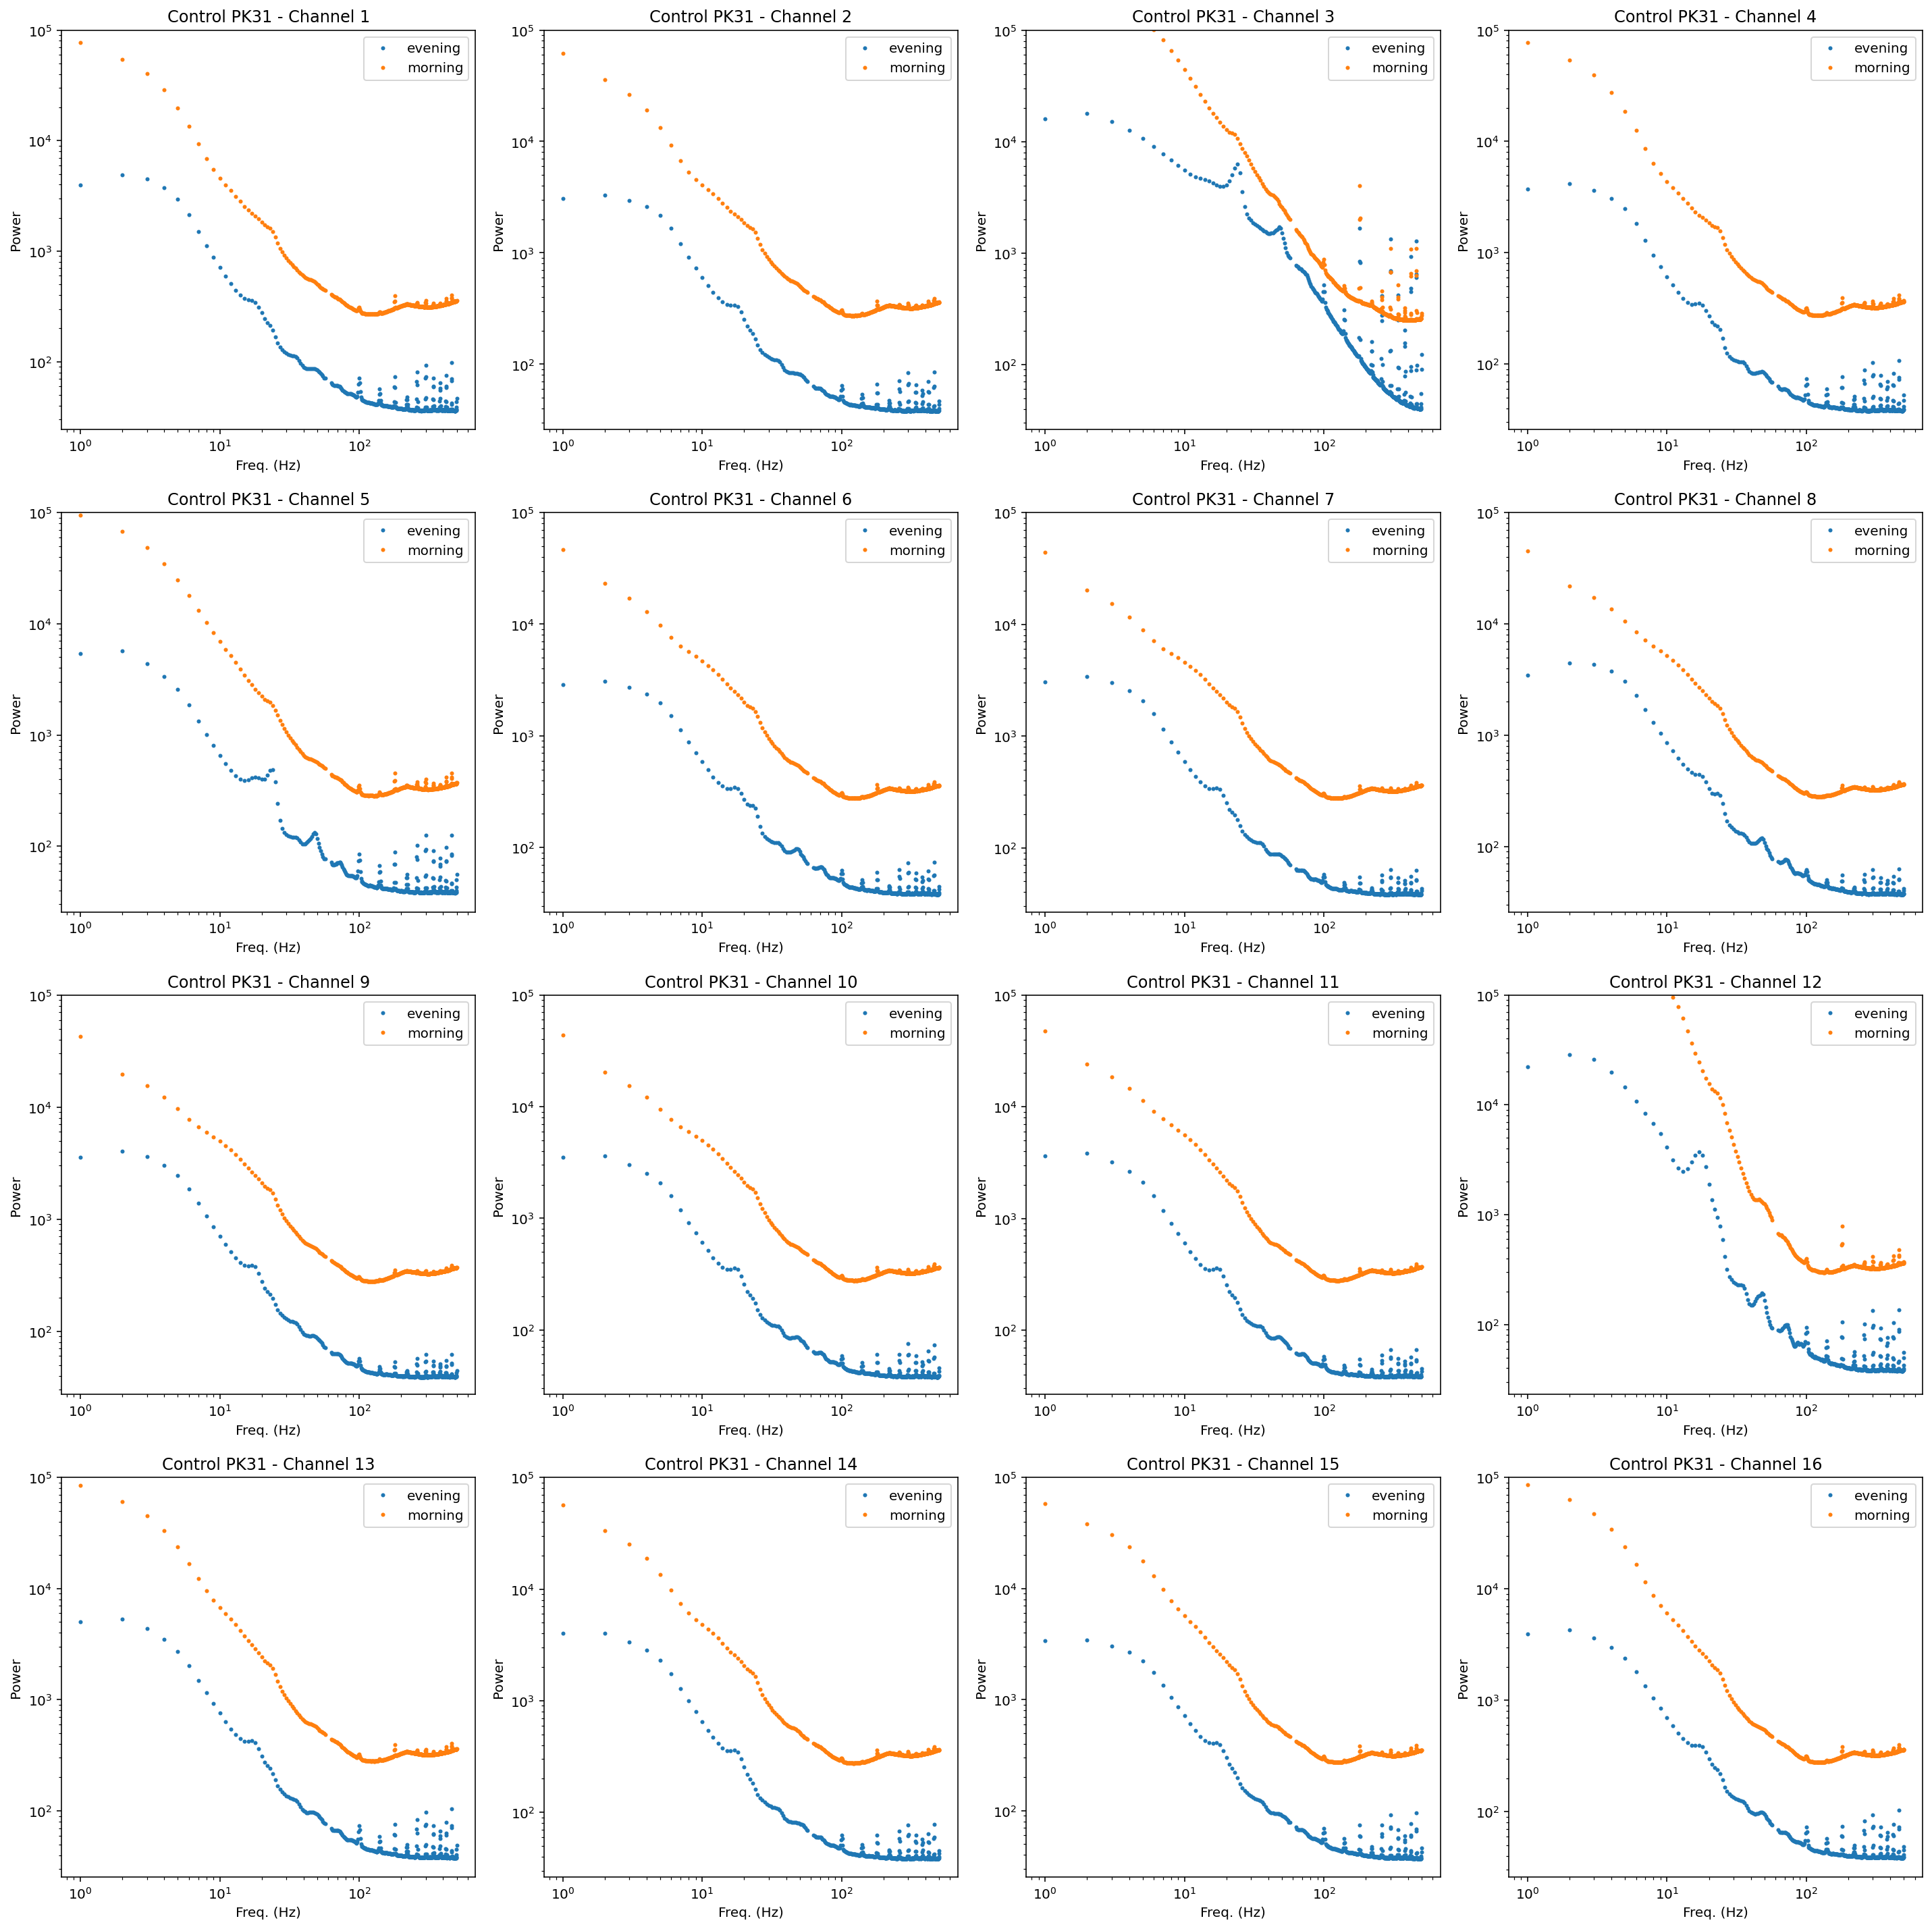

In [39]:
plot_channels(df_bird2_test, bird2)

#### !!! Manually define channels with broken electrodes to be removed from bird 2 data OR define single channel to keep

Note: Based on wavelet transform data during singing, we decided to keep channels 2, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15 for PK31.

In [40]:
# If averaging over multiple channels:
# Define channels with broken electrodes to remove (leave array empty if none)
bad_channels_b2 = [1, 3, 5, 12, 16]

# If only keeping one single channel (ignored if channels_used == "multi"):
single_channel2 = 10

In [41]:
if channels_used == "single":
    bad_channels_b2 = df_bird2['channel'].unique()[df_bird2['channel'].unique() != single_channel2]

In [42]:
for bad_channel in np.concatenate((bad_channels_b2, outside_HVC)):
    # Exclude bad channels and channels located outside HVC from test df (power values averaged across all days)
    df_bird2_test = df_bird2_test[df_bird2_test.channel != bad_channel]
    
    # Excluse bad channels and channels located outside HVC from original df
    df_bird2 = df_bird2[df_bird2.channel != bad_channel]
    
# for bad_channel in bad_channels_b2:
#     # Exclude bad channels from test df (power values averaged across all days)
#     df_bird2_test = df_bird2_test[df_bird2_test.channel != bad_channel]
    
#     # Excluse bad channels from original df
#     df_bird2 = df_bird2[df_bird2.channel != bad_channel]

In [43]:
# Show new channel list
df_bird2["channel"].unique()

array([ 2,  4,  6,  8, 10, 14])

___

# Compare Power/Freq graph between animals by averaging across all channels

Average power values across all channels (excluding bad channels):

In [44]:
# Bird 1
df_bird1_test_2 = df_bird1_test.groupby(["daytime", "freq"])[["power"]].apply(np.mean)
df_bird1_test_2 = df_bird1_test_2.reset_index()

# Bird 2
df_bird2_test_2 = df_bird2_test.groupby(["daytime", "freq"])[["power"]].apply(np.mean)
df_bird2_test_2 = df_bird2_test_2.reset_index()

/var/folders/v8/1_xrn19n71s8w4gbd_215tnr0000gn/T/ipykernel_2368/2452910435.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


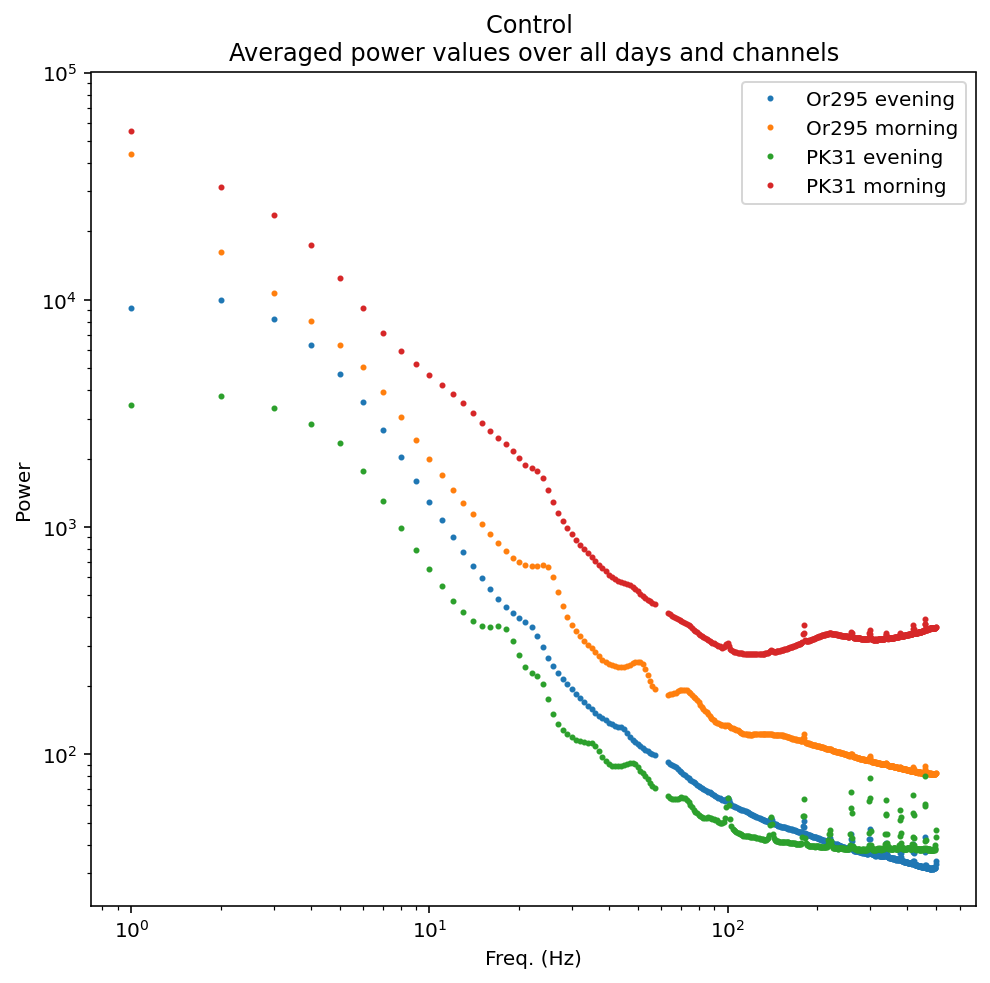

In [45]:
fig, ax = plt.subplots(figsize=(7, 7))

for name, group in df_bird1_test_2.groupby("daytime"):
    ax.plot(group["freq"], group["power"], label=f"{bird1} {name}", marker='o', markersize=2, linestyle='', linewidth=2)
    
for name, group in df_bird2_test_2.groupby("daytime"):
    ax.plot(group["freq"], group["power"], label=f"{bird2} {name}", marker='o', markersize=2, linestyle='', linewidth=2)

ax.set(**{
    "xlabel": "Freq. (Hz)",
    "ylabel": "Power",
    "title": "{} \nAveraged power values over all days and channels".format(condition)
})

# Change axes to log scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(top=100000)

# Add legend
ax.legend()
    
plt.tight_layout()    
fig.show()

___

# Multiple Linear Model

In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [95]:
lm = LinearRegression()

Check R^2 for linear model between power and each variable for both birds:

Bird 1:

In [102]:
# Find variable most correlated to power (other than power)
df_bird1.corr()['power'].sort_values()

freq      -0.018158
hour      -0.005636
day       -0.000514
channel   -0.000332
power      1.000000
Name: power, dtype: float64

In [100]:
Xs = ["day", "channel", "hour", "freq"]
Y = df_bird1["power"]

for variable in Xs:
    X = df_bird1[[variable]]
    lm.fit(X, Y)
    r2 = lm.score(X, Y)
    perc = int(r2 * 100)
    print(f"{perc}% of the variability of the power values can be explained by {variable}") 

0% of the variability of the power values can be explained by day
0% of the variability of the power values can be explained by channel
0% of the variability of the power values can be explained by hour
0% of the variability of the power values can be explained by freq


Bird 2:

In [103]:
# Find variable most correlated to power (other than power)
df_bird2.corr()['power'].sort_values()

freq      -0.034163
hour      -0.023165
channel   -0.001060
day        0.011046
power      1.000000
Name: power, dtype: float64

In [101]:
Xs = ["day", "channel", "hour", "freq"]
Y = df_bird2["power"]

for variable in Xs:
    X = df_bird2[[variable]]
    lm.fit(X, Y)
    r2 = lm.score(X, Y)
    perc = int(r2 * 100)
    print(f"{perc}% of the variability of the power values can be explained by {variable}") 

0% of the variability of the power values can be explained by day
0% of the variability of the power values can be explained by channel
0% of the variability of the power values can be explained by hour
0% of the variability of the power values can be explained by freq


___

Fit power for bird 1 against all other variables:

In [48]:
Z = df_bird1[["day", "channel", "hour", "freq"]]

In [49]:
%%time
lm.fit(Z, df_bird1["power"])

CPU times: user 220 ms, sys: 53.6 ms, total: 273 ms
Wall time: 152 ms


LinearRegression()

In [50]:
Yhat = lm.predict(Z)
lm.coef_

array([ -0.31947029,  -1.30349596, -30.92009464,  -2.33401134])

Plot eCDF:

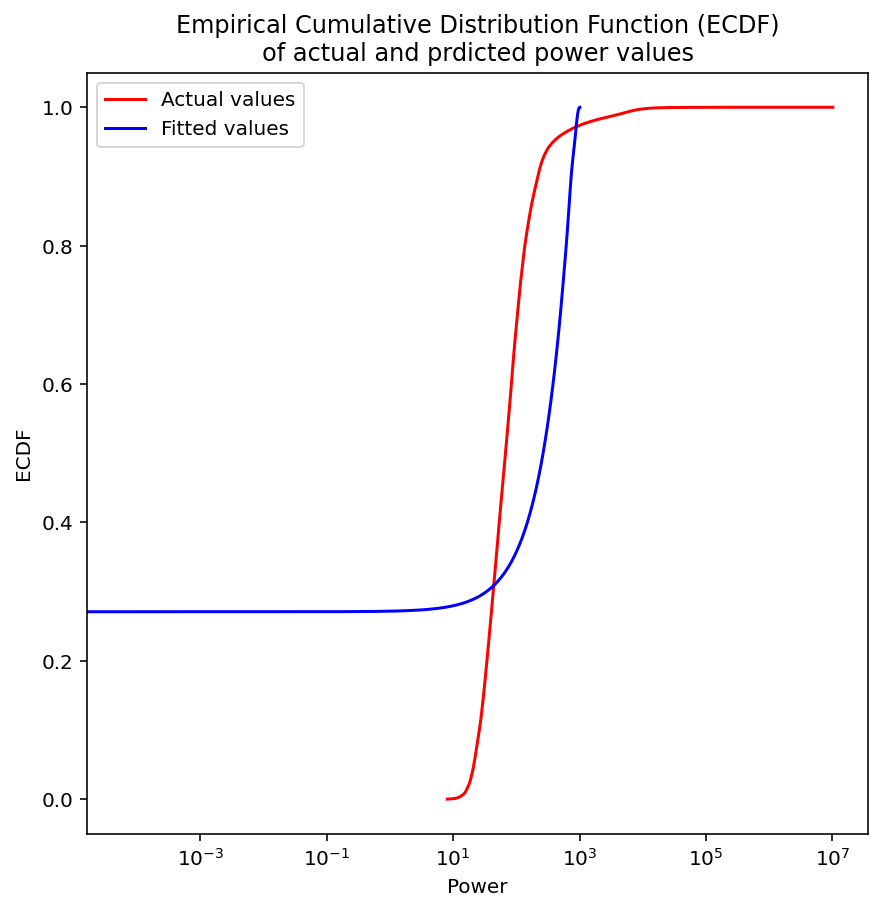

In [63]:
fig, ax = plt.subplots(figsize=(7, 7))

x = np.sort(df_bird1["power"])
y = np.arange(len(x))/float(len(x))
ax.plot(x, y, color="red", label="Actual values")

x = np.sort(Yhat)
y = np.arange(len(x))/float(len(x))
ax.plot(x, y, color="blue", label="Fitted values")

ax.set(**{
    "xlabel": "Power",
    "ylabel": "ECDF",
    "title": "Empirical Cumulative Distribution Function (ECDF)\nof actual and prdicted power values".format(condition)
})

ax.set_xscale('log')

ax.legend()

In [83]:
MSE = mean_squared_error(df_bird1["power"], Yhat)
print(f"MSE = {MSE}")

MSE = 341444160.4785129
